<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-Walt9819/blob/main/Week7/TecMty_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [165]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [166]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [167]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [168]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [170]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

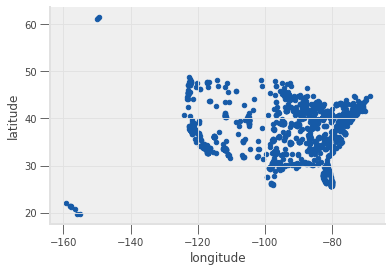

In [171]:
#extrae los datos interesantes
latlong.plot.scatter("longitude","latitude")

In [172]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [173]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [174]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [175]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [176]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [177]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

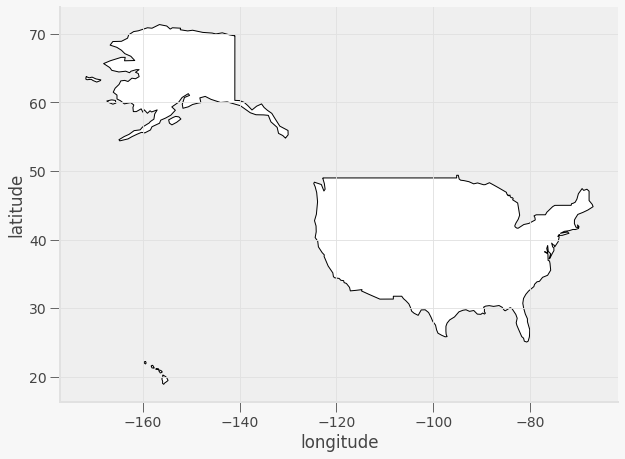

In [178]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

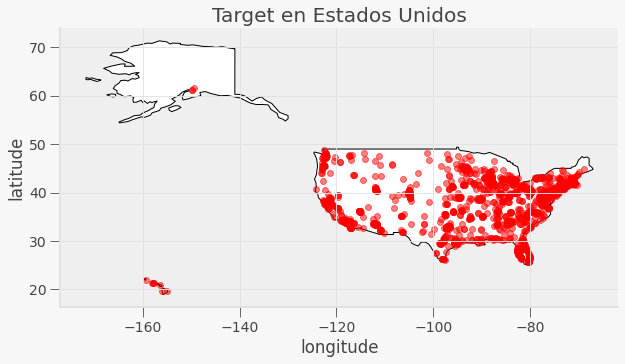

In [179]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

#### Make k-means

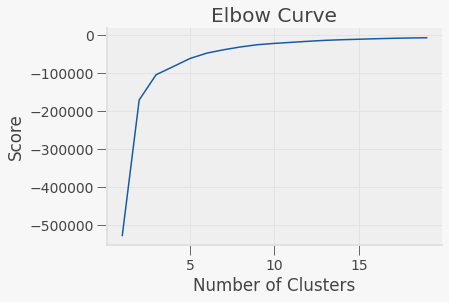

In [180]:
from sklearn.cluster import KMeans

X = latlong

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

En este caso se puede ver que alrededor de 7 clusters es un buen valor. Procedemos a entrenar con ese número de clusters.

In [186]:
kmeans = KMeans(n_clusters=7, random_state=101).fit(X)
# Getting the cluster centers
centroids = kmeans.cluster_centers_
print(centroids)

[[  31.14437802  -82.90148008]
 [  46.85427042 -121.87553891]
 [  35.4611968  -117.26588508]
 [  41.77295911  -88.76508852]
 [  40.3424011   -75.65255351]
 [  33.91387391  -98.30400259]
 [  20.94542771 -157.31225085]]


Visualizamos cómo están distribuidos los clústers para las tiendas

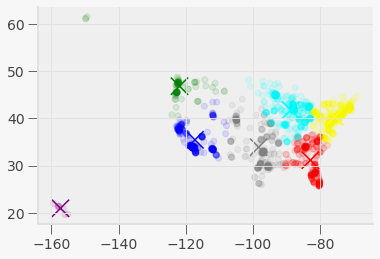

In [187]:
labels = kmeans.predict(X)
colors=['red','green','blue','cyan','yellow', 'gray', 'purple']
values=[]
for row in labels:
    values.append(colors[row])
 
fig = plt.figure()
plt.scatter(X["longitude"], X["latitude"], c=values, alpha=0.1)
plt.scatter(centroids[:, 1], centroids[:, 0], marker='x', c=colors, s=300, alpha=1)

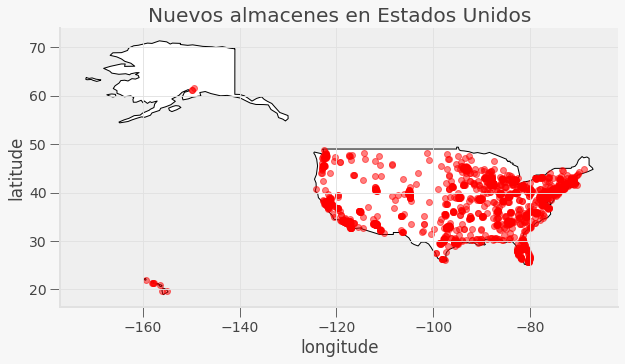

In [188]:
fig, gax = plt.subplots(figsize=(10,10))
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Nuevos almacenes en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Locate centroids cities

In [190]:
import pandas as pd
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

centroids_data = {"state": [], "longitude": [], "latitude": [], "number of stores": []}

for i, c in enumerate(centroids):
  location = f'{c[0]},{c[1]}'
  location = geolocator.reverse(location)
  # Information
  address = location.raw['address']
  # traverse the data
  state = address.get('state', '')
  centroids_data["state"].append(state)
  centroids_data["latitude"].append(c[0])
  centroids_data["longitude"].append(c[1])
  centroids_data["number of stores"].append(np.sum(labels == i))

centroids_df = pd.DataFrame(centroids_data)

In [191]:
centroids_df

,state,longitude,latitude,number of stores
0,Georgia,-82.901480,31.144378,272
1,Washington,-121.875539,46.854270,79
2,California,-117.265885,35.461197,283
3,Illinois,-88.765089,41.772959,436
4,Pennsylvania,-75.652554,40.342401,484
5,Texas,-98.304003,33.913874,277
6,,-157.312251,20.945428,8


In [192]:
centroids_df["Coordinates"] = list(zip(centroids_df.longitude, centroids_df.latitude))
centroids_df["Coordinates"] = centroids_df["Coordinates"].apply(Point)
gcentroids = gpd.GeoDataFrame(centroids_df, geometry="Coordinates")
gcentroids

,state,longitude,latitude,number of stores,Coordinates
0,Georgia,-82.901480,31.144378,272,POINT (-82.90148 31.14438)
1,Washington,-121.875539,46.854270,79,POINT (-121.87554 46.85427)
2,California,-117.265885,35.461197,283,POINT (-117.26589 35.46120)
3,Illinois,-88.765089,41.772959,436,POINT (-88.76509 41.77296)
4,Pennsylvania,-75.652554,40.342401,484,POINT (-75.65255 40.34240)
5,Texas,-98.304003,33.913874,277,POINT (-98.30400 33.91387)
6,,-157.312251,20.945428,8,POINT (-157.31225 20.94543)


Check the missing one

In [194]:
location = f'{centroids[6, 0]},{centroids[6, 1]}'
location = geolocator.reverse(location)
location

Location(United States, (39.7837304, -100.445882, 0.0))

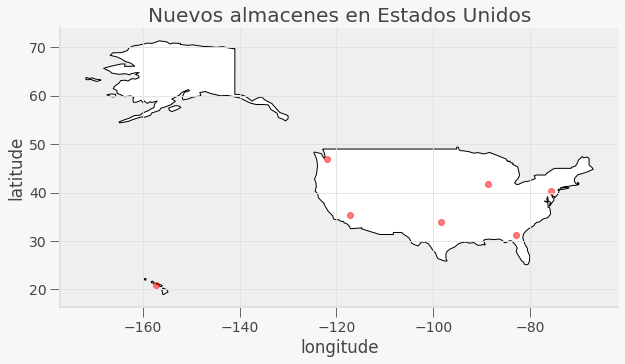

In [195]:
fig, gax = plt.subplots(figsize=(10,10))
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gcentroids.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Nuevos almacenes en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Set the distance and location of each warehouse to the stores

In [196]:
from geopy import distance

to_add = {"distance in km": [], "cluster": []}
for i, (store, store_info) in enumerate(gdf.iterrows()):
  label = labels[i]
  warehouse = centroids_df.iloc[label, :]
  w_pos = (warehouse["latitude"], warehouse["longitude"])
  s_pos = (store_info["latitude"], store_info["longitude"])
  to_add["cluster"].append(warehouse["state"])
  to_add["distance in km"].append(distance.distance(w_pos, s_pos).km)

In [197]:
stores_df = gdf.copy()
stores_df["distance in km"] = to_add["distance in km"]
stores_df["cluster"] = to_add["cluster"]

In [198]:
stores_df.head()

,name,latitude,longitude,address,phone,website,Coordinates,distance in km,cluster
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423),434.277507,Georgia
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455),455.402323,Georgia
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287),481.334409,Georgia
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015),537.162317,Georgia
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606),242.900272,Georgia


Check the nearest cities of the missing one

In [199]:
stores_df[stores_df["cluster"] == ""]

,name,latitude,longitude,address,phone,website,Coordinates,distance in km,cluster
527,Hawaii Hilo,19.701031,-155.059994,"391 E Makaala St., Hilo, HI 96720-5146",808-920-8605,https://www.target.com/sl/hawaii-hilo/2682,POINT (-155.05999 19.70103),272.576251,
528,Maui Kahului,20.874842,-156.456209,"100 Hookele St, Kahului, HI 96732-3509",808-359-2829,https://www.target.com/sl/maui-kahului/2660,POINT (-156.45621 20.87484),89.398283,
529,Oahu Kailua,21.391428,-157.739430,"345 Hahani St, Kailua, HI 96734-2838",808-489-9319,https://www.target.com/sl/oahu-kailua/2697,POINT (-157.73943 21.39143),66.382349,
530,Hawaii Kona,19.647855,-156.002677,"74-5455 Makala Blvd, Kailua Kona, HI 96740-2727",808-334-4020,https://www.target.com/sl/hawaii-kona/2412,POINT (-156.00268 19.64786),198.354752,
531,Oahu Kapolei,21.331204,-158.090252,"4450 Kapolei Pkwy, Kapolei, HI 96707-1878",808-457-3679,https://www.target.com/sl/oahu-kapolei/2411,POINT (-158.09025 21.33120),91.407291,
532,Lihue Kauai,21.968086,-159.376962,"4303 Nawiliwili Rd, Lihue, HI 96766-9581",808-212-0223,https://www.target.com/sl/lihue-kauai/3400,POINT (-159.37696 21.96809),242.113304,
533,Oahu Honolulu Salt Lake,21.356890,-157.928377,"4380 Lawehana St, Honolulu, HI 96818-3137",808-441-3118,https://www.target.com/sl/honolulu/2410,POINT (-157.92838 21.35689),78.553341,
534,Oahu Honolulu Ala Moana,21.292086,-157.844105,"1450 Ala Moana Blvd, Ste 2401, Honolulu, HI 96...",808-206-7162,https://www.target.com/sl/honolulu/2870,POINT (-157.84411 21.29209),67.275919,


In [200]:
missing_warehouse = "Hawaii/Oahu"
stores_df.loc[stores_df["cluster"] == "", "cluster"] = missing_warehouse
gcentroids.loc[gcentroids["state"] == "", "state"] = missing_warehouse

Distance range for each warehouse location

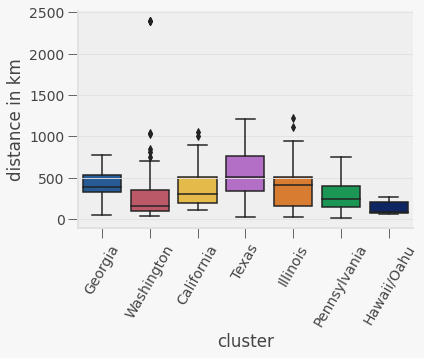

In [201]:
import seaborn as sns

ax = sns.boxplot(data=stores_df, x="cluster", y="distance in km")
plt.xticks(rotation=60);

### Geographic libraries

En particular la librería de Geopandas resulta extremadamente útil, ya que te permite obtener los datos de diferentes fuentes e importarlos de una manera estándar para posteriormente usarlos y hacer los mapas; incluso con datos propios.

Otra opción es plotly, la cual brinda también una gran variedad de herramientas para graficar sobre mapas.

Por otro lado, existen muchas otras librerías que brindan la posiblidad de trabajar con datos geográficos, en particular en esta práctica se ocupó la de ````geopy```, misma que permitió encontrar las ciudades donde se encuentran los almacenes tan solo con la información de su longitud y latitud. Además de ello, permite también medir las distancias entre dos puntos terrestres con los mismos datos de cada uno.

En conclusión, poder colocar los datos en un mapa es una herramienta crucial, por ejemplo para el caso de valores donde en realidad no exista "haya" tierra, es decir, el punto calculado sea en el mar. En estos casos, al tener un mapa (y las otras herramientas ya mencionadas) fácilmente se puede notar este detalle para poderlo atender de forma particular. 